# HI! If you're unfamiliar with Colab here's how to start:
1. Create your own copy of this file by clicking `File` → `Save A Copy In Drive`
2. Follow the prompt to sign into your Google account if necessary to open the new file in your own GDrive. Once you're in your own copy you will be able to make edits, which will allow you to use the sliders on the graphs.
3. Run all of the cells by clicking `Runtime` → `Run All`
4. As stated below, the first cell will prompt you to `Restart Session` to allow some installed files to take effect. Click restart session and/or refresh the page. You may need to repeat step 3.
5. Feel free to look around, but the two cells with graphs of the results are together at the very bottom. Play around with the sliders to see all of the data. I've noticed that very rarely the sliders happen to disappear for some reason. If that happens you can click `shift` + `enter` on the code line above it to refresh the graph and view the sliders.

there's an issue with the newest versions of plotly interacting with the interactive features of ipywidget. You need to run this cell and restart the colab session before running all of the others

In [225]:
pip install plotly==5.10

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.2/15.2 MB 62.1 MB/s eta 0:00:00
  Attempting uninstall: plotly
    Found existing installation: plotly 5.24.1
    Uninstalling plotly-5.24.1:
      Successfully uninstalled plotly-5.24.1


In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
import os
from ipywidgets import interact, interactive
import ipywidgets as widgets
print(torch.__version__)

2.5.1+cu121


In [2]:
# cheating in some variables here from some other data processing I did in a different project
MEAN_LAT = 38.28132872306216
MEAN_LNG = -91.65855796075903

In [3]:
# copying in the draw counties method for our visualizations
drawing_data = 'https://www.tyro.work/cont-us-counties-latlng-normalized.csv'
if not os.path.exists('/content/cont-us-counties-latlng-normalized.csv'):
  !wget $drawing_data
else:
  print("County Location Data has already been downloaded.")

drawing_df = pd.read_csv('/content/cont-us-counties-latlng-normalized.csv')
draw_lat_tensor = torch.tensor(drawing_df['lat'].values)
draw_lat_tensor = draw_lat_tensor.reshape(-1, 1)
draw_lng_tensor = torch.tensor(drawing_df['lng'].values)
draw_lng_tensor = draw_lng_tensor.reshape(-1, 1)
# i thought we needed to vstack these, but we actually need hstack
draw_lnglat_tensor = torch.hstack((draw_lng_tensor, draw_lat_tensor))
# print("county data shape: ", draw_lnglat_tensor.shape)
# print('county data: ', draw_lnglat_tensor)
# these constants will be useful for randomizing our centroids
lat_max = draw_lat_tensor.max().item()
lat_min = draw_lat_tensor.min().item()
lng_max = draw_lng_tensor.max().item()
lng_min = draw_lng_tensor.min().item()

def draw_counties():
  plt.figure(figsize = (8,5))
  plt.scatter(draw_lnglat_tensor[:, 0], draw_lnglat_tensor[:, 1], c='#79d2a4', marker='.', s=4, label='U.S. Counties')
  plt.xlabel('Longitude')
  plt.ylabel('Latitude')
  # Instead of converting all the data back to normal latitudes and longitudes, I'm gonna just hack the axis x_labels
  x_locs, x_labels = plt.xticks()
  x_labels = [int(item + MEAN_LNG) for item in x_locs]
  plt.xticks(x_locs, x_labels)
  y_locs, y_labels = plt.yticks()
  y_labels = [int(item + MEAN_LAT) for item in y_locs]
  plt.yticks(y_locs, y_labels)

# now we have a method to quickly draw the county locations
# draw_counties()

County Location Data has already been downloaded.


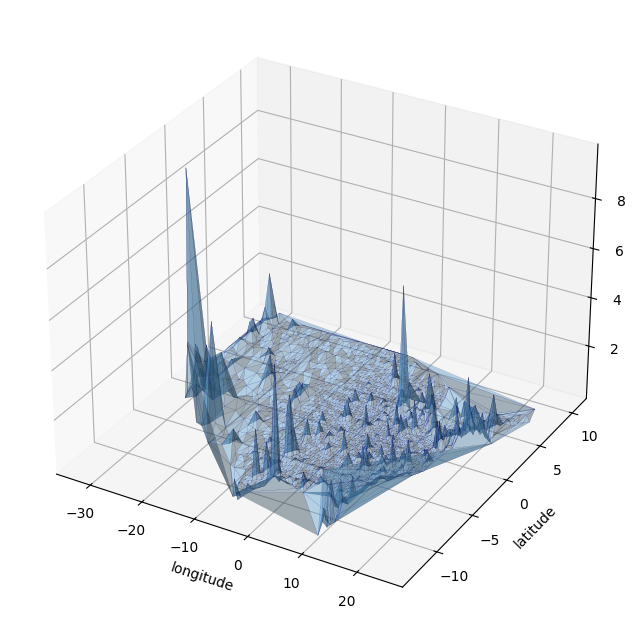

In [4]:
# from the old work I did on https://github.com/Tyrowo/us-county-data-processing-and-visualization/blob/main/data%20visualization.py
# just using the current files instead. Unfortunately 3dmatplotlib plots don't work on Colab, but I've included it just because it looks nice.

y = drawing_df['lat'].to_list()
x = drawing_df['lng'].to_list()
z = drawing_df['population'].to_list()
# lat: [25.3192, 48.8259] and lng: [-124.1568, -67.6287]
lat_dist = 48.8259 - 25.3192
lng_dist = 124.1568 - 67.6287

fig = plt.figure(figsize=(12, 8))
# plt.gca().set_aspect('equal')
ax = fig.add_subplot(111, projection='3d')
# #56a0d3 = carolina blue, #000080 = navy, alpha is transparency, linewidths should be small because there's a lot
ax.plot_trisurf(x,y,z, color='#56a0d3', edgecolors='#000080', alpha=0.4, linewidths=0.05)
# ax.scatter(x,y,z, c='white', alpha = 0.05, marker='.')
# Add labels and title
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')
ax.set_zlabel('population')
# plt.plot(x, y, markersize=2, linestyle='None')
plt.show()

In [5]:
model_pytorch = 'https://www.tyro.work/optimized_model.pth'
if not os.path.exists('/content/optimized_model.pth'):
  !wget $model_pytorch
else:
  print("Model has already been downloaded.")

k_means_pytorch = 'https://www.tyro.work/k_means_model_data.pth'
if not os.path.exists('/content/k_means_model_data.pth'):
  !wget $k_means_pytorch
else:
  print("K Means Data has already been downloaded.")

Model has already been downloaded.
K Means Data has already been downloaded.


In [6]:
optimized_model = torch.load('/content/optimized_model.pth')

# [k_loss, k_init_centroids, k_final_centroids, k_end_centroid_count] is the consturction of the optimized model
k_loss = optimized_model[0]
k_init_centroids = optimized_model[1]
k_final_centroids = optimized_model[2]
k_end_centroid_count = optimized_model[3]

# print(k_end_centroid_count)
print('loaded model successfully')

# now need to load the test set as a model
k_means_data = torch.load('/content/k_means_model_data.pth')

# [training_set, testing_set, LAT_RANGE, LNG_RANGE, LAT_SHIFT, LNG_SHIFT]
training_set = k_means_data[0]
testing_set = k_means_data[1]
LAT_RANGE = k_means_data[2]
LNG_RANGE = k_means_data[3]
LAT_SHIFT = k_means_data[4]
LNG_SHIFT = k_means_data[5]
# print("lat range")
# print(LAT_RANGE)
# print("lng range")
# print(LNG_RANGE)
# print("lat shift")
# print(LAT_SHIFT)
# print("lng shift")
# print(LNG_SHIFT)
# print('training set')
# print(training_set)
# print('testing set')
# print(testing_set)
# print(' ')
print('loaded k means data successfully')

loaded model successfully
loaded k means data successfully


<ipython-input-6-29822c86fe73>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  optimized_model = torch.load('/content/optimized_model.pth')
<ipython-input-6-29822c86fe73>:1

In [70]:
# optimized_model = [k_loss, k_init_centroids, k_final_centroids, k_end_centroid_count]
ks = [i for i in range(350)]
centroid_reduction = [ks[i] - k_end_centroid_count[i] for i in range(len(ks))]
# print(len(ks), len(k_loss))

def draw_k(K = 225, Show_Initial_Centroids=False, Loss_Start=25):
  # Initialise the subplot function using number of rows and columns
  figure, axis = plt.subplots(1, 3, figsize=(30, 5))
  # draw_counties(), recreated for subplots:
  axis[0].scatter(draw_lnglat_tensor[:, 0], draw_lnglat_tensor[:, 1], c='#79d2a4', marker='.', s=4, label='U.S. Counties')
  axis[0].set_xlabel('Longitude')
  axis[0].set_ylabel('Latitude')
  if Show_Initial_Centroids:
    axis[0].scatter(k_init_centroids[K][:, 0], k_init_centroids[K][:, 1], c='r', s=50, marker='1', label='Randomized Initialization')
  axis[0].scatter(k_final_centroids[K][:, 0], k_final_centroids[K][:, 1], c='b', s=50, marker='2', label=f'{k_end_centroid_count[K]} Optimized Centroids')
  axis[0].set_title(f'K-Means Optimized Centroids For K={K}')
  axis[0].legend(loc='lower left')

  left_bound = 1 if not Loss_Start else Loss_Start
  axis[1].plot(ks[left_bound:], k_loss[left_bound:], c='#56a0d3', marker='o', label='All Losses')
  axis[1].plot([K], k_loss[K], c='r', marker=7, markersize=25, label=f'Loss At K={K}')
  axis[1].set_title(f'For {K} Centroid{"s" if K > 1 else ""} Euclidian-Derived Loss Was {k_loss[K]}')
  handles, labels = axis[1].get_legend_handles_labels()
  axis[1].legend(reversed(handles), reversed(labels), loc='center right')

  # finally, just a simple plot of how many centroids were lost at each value of k
  axis[2].bar(ks, centroid_reduction, color='#56a0d3', label='Removed Centroids')
  axis[2].plot([K], centroid_reduction[K], c='r', marker=7, markersize=25, label='Starting K Centroids')
  axis[2].set_title(f'For {K} Starting Centroid{"s" if K > 1 else ""} {centroid_reduction[K]} Centroid{"s Were" if centroid_reduction[K] != 1 else " Was"} Removed For Redundance')
  axis[2].legend(loc='center left')

  # Instead of converting all the data back to normal latitudes and longitudes, I'm gonna just hack the axis x_labels
  # but for subplots need to finesse this with the .sca command
  plt.sca(axis[0])
  x_locs, x_labels = plt.xticks()
  x_labels = [int(item + MEAN_LNG) for item in x_locs]
  plt.xticks(x_locs, x_labels)
  y_locs, y_labels = plt.yticks()
  y_labels = [int(item + MEAN_LAT) for item in y_locs]
  plt.yticks(y_locs, y_labels)

  plt.show()
  return

# grid = widgets.Grid(2, 2)
slider = widgets.IntRangeSlider(
    value=[5, 7],
    min=0,
    max=10,
    step=1,
    description='Test:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)
# plot = interact(draw_k, K=(1, 349), Loss_Start=(0, 345, 25))

In [71]:
# matplotlib 3d plots don't work with colab notebooks so here's a plotly version
# produced some plotly code with Claude ai
import numpy as np
import plotly.graph_objs as go

# Plotly 3D Trisurf Plot with Custom Color Scale
color_options = {
      'Deep': 'red',
      'Temps': 'black',
      'Armyrose':'black',
      'Curl':'orange',
      'BrBG':'black',
      'Tealrose':'black'
}

def create_trisurf_plot(ColorScheme='Tealrose', Show_K_Centroids=False, K=225):
    """
    Create a 3D trisurf plot using Plotly with custom color scale

    Parameters:
    x (array-like): x-coordinates
    y (array-like): y-coordinates
    z (array-like): z-coordinates
    vmin (float, optional): Minimum value for color scaling
    vmax (float, optional): Maximum value for color scaling

    Returns:
    Plotly Figure object
    """
    y = drawing_df['lat'].to_list()
    x = drawing_df['lng'].to_list()
    z = drawing_df['population'].to_list()

    vmin = 5
    vmax=None
    opacity_choice = 0.575 if Show_K_Centroids else 1

    # If vmin or vmax are not provided, calculate them
    if vmin is None:
        vmin = np.percentile(z, 1)  # 1st percentile
    if vmax is None:
        vmax = np.percentile(z, 99)  # 99th percentile

    # Create the trisurf plot
    trace = go.Mesh3d(
        x=x,
        y=y,
        z=z,
        colorscale=ColorScheme,  # You can change this to other color scales
        intensity=z,
        cmin=vmin,  # Set minimum for color scaling
        cmax=vmax,  # Set maximum for color scaling
        showscale=True,
        opacity=opacity_choice
    )
    # Create a scatter plot of k values if desired
    # if turn_on_scatter:

    scatter_x = k_final_centroids[K][:, 0]
    scatter_y = k_final_centroids[K][:, 1]
    scatter_z = [-1 for i in range(K)]
    scatter_trace = go.Scatter3d(
        x=scatter_x, #k_final_centroids[225][:, 0],
        y=scatter_y, #k_final_centroids[225][:, 1],
        z=scatter_z, #[1000000 for i in range(225)],
        mode='markers',
        marker=dict(
            size=3,
            color=color_options[ColorScheme],
            opacity=1
        )
    )

    # calculate the ticks
    x_ticks = np.linspace(min(x), max(x), 5)  # 5 ticks across the range
    y_ticks = np.linspace(min(y), max(y), 5)
    z_ticks = np.linspace(min(z), max(z), 5)

    # Configure the layout
    layout = go.Layout(
        title=f'U.S. Population By County With {k_end_centroid_count[K]} Centroids' if Show_K_Centroids else 'U.S. Population By County',
        width=750,  # Width in pixels
        height=750,
        scene=dict(
            zaxis_title='Population',

            xaxis=dict(
                title='Longitude',
                tickvals=x_ticks,  # Original data points
                ticktext=[int(i + MEAN_LNG) for i in x_ticks],  # Custom tick labels
            ),
            yaxis=dict(
                title='Latitude',
                tickvals=y_ticks,  # Original data points
                ticktext=[int(i + MEAN_LAT) for i in y_ticks],  # Custom tick labels
            ),
        )
    )

    # Create the figure
    plot_data = [trace]
    if Show_K_Centroids:
      plot_data.append(scatter_trace)
    fig = go.Figure(data=plot_data, layout=layout)
    fig.update_layout(
      scene=dict(
          camera=dict(
              eye=dict(x=0.25, y=-1.25, z=1.15)  # Adjust viewing angle
          )
      )
    )
    fig.show()

    return




def draw_trisurf(ColorScheme='Tealrose', K=225, Show_K_Centroids=False):
  # Create and show the plot
  # fig = go.Figure()
  fig = create_trisurf_plot(ColorScheme, K, Show_K_Centroids)
  fig.show()
  return fig

# fig = create_trisurf_plot(ColorScheme ='Tealrose', opacity_choice=0.7, Show_K_Centroids=True, K=225)
# plot = interact(create_trisurf_plot, ColorScheme=list(color_options.keys()), K=(1, 349), opacity_choice=(0.1, 1.0, 0.1))
# If you want to save the plot
# fig.write_html("trisurf_plot.html")

# and finally create a dropdown interaction bar with all the coolest looking colors
# https://plotly.com/python/builtin-colorscales/

# Here are final visualizations of the results

In [72]:
plot = interact(draw_k, K=(1, 349), Loss_Start=(0, 345, 25))

interactive(children=(IntSlider(value=225, description='K', max=349, min=1), Checkbox(value=False, description…

In [69]:
plot = interact(create_trisurf_plot, ColorScheme=list(color_options.keys()), K=(1, 349), opacity_choice=(0.1, 1.0, 0.1))

interactive(children=(Dropdown(description='ColorScheme', index=5, options=('Deep', 'Temps', 'Armyrose', 'Curl…

# Thanks for viewing my project!
If you have any questions feel free to reach out at tylerpcrews@gmail.com


    -Tyler "Tyro" Crews